# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [1]:
import os
import time

# wait_to_make = "trained_list/patent-bert-plain.txt"

# count = 0
# while 1:
#     if os.path.exists(wait_to_make):
#         break
#     print(f'sleep {count} h')
#     time.sleep(3600)
#     count+=1
    


In [2]:
EXP_NAME = "funnel-transformer-large-sep"


In [3]:
# !nvidia-smi

In [4]:
# ! pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [5]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0+cu111
True


# Directory settings

In [6]:
# ====================================================
# Directory settings
# ====================================================

import os
import datetime

INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'
dt_now = datetime.datetime.now()

date = dt_now.strftime('%Y-%m-%d-%H-%M-%S')
 
OUTPUT_DIR = f'./output/{EXP_NAME}/'
# if not os.path.exists(OUTPUT_DIR):
os.makedirs(OUTPUT_DIR, exist_ok=True)


# CFG

In [7]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    # _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    # model="microsoft/deberta-v3-large"
    model = "funnel-transformer/large"
    # size = "large
    # model = f"{model}-{size}"
    if "small" in model:
        hidden_state = hiddden_state_fix = 512
    elif "base" in model:
        hidden_state = hiddden_state_fix = 768
    elif "large" in model:
        hidden_state = hiddden_state_fix = 1024
    elif "xlarge" in model:
        hidden_state =  1536
        
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    
    batch_size=8
    
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[i for i in range(n_fold)]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [8]:
# # ====================================================
# # wandb
# # ====================================================
# if CFG.wandb:
    
#     import wandb

#     try:
#         from kaggle_secrets import UserSecretsClient
#         user_secrets = UserSecretsClient()
#         secret_value_0 = user_secrets.get_secret("wandb_api")
#         wandb.login(key=secret_value_0)
#         anony = None
#     except:
#         anony = "must"
#         print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


#     def class2dict(f):
#         return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

#     run = wandb.init(project='PPPM-Public', 
#                      name=CFG.model,
#                      config=class2dict(CFG),
#                      group=CFG.model,
#                      job_type="train",
#                      anonymous=anony)

In [9]:
# !pip install transformers==4.16.2
# !pip install tokenizers==0.11.0

# Library

In [10]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

start = time.time()

torch.__version__: 1.9.0+cu111
tokenizers.__version__: 0.11.6
transformers.__version__: 4.17.0
env: TOKENIZERS_PARALLELISM=true
cuda


# Utils

In [11]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [12]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [13]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir(INPUT_DIR+'CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'{INPUT_DIR}CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


# cpc_texts = get_cpc_texts()
# torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
cpc_texts = torch.load(INPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [14]:
pad = "<sep>"#"[SEP]"
train['text'] = train['anchor'] + pad + train['target'] +pad  + train['context_text']
test['text'] = test['anchor'] + pad + test['target'] +pad  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement<sep>abatement of pollution<sep>HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement<sep>act of abating<sep>HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement<sep>active catalyst<sep>HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement<sep>eliminating process<sep>HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement<sep>forest region<sep>HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum<sep>inorganic photoconductor drum<sep...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow<sep>altering gas flow<sep>MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion<sep>lower locating<sep>PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component<sep>upper portion<sep>TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation<sep>artificial neural netwo...


# EDA

<AxesSubplot:>

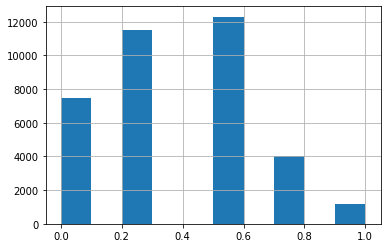

In [15]:
train['score'].hist()

In [16]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [17]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    9119
1    9118
2    9118
3    9118
dtype: int64

In [18]:
# !pip install -q iterative-stratification

In [19]:
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
# cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
# dfx = dfx[cols]

# mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
# labels = [c for c in dfx.columns if c != "anchor"]
# dfx_labels = dfx[labels]
# dfx["fold"] = -1

# for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
#     print(len(trn_), len(val_))
#     dfx.loc[val_, "fold"] = fold

# train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
# print(train.fold.value_counts())

In [20]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [21]:
# !pip install --no-cache-dir sentencepiece

In [22]:
# ====================================================
# tokenizer
# ====================================================
# tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer



# Dataset

In [23]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 125


In [24]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

sys.path.append('../dataset')
from dataset import TrainDataset

torch.__version__: 1.9.0+cu111


In [25]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [26]:
# # ====================================================
# # Model
# # ====================================================
# class CustomModel(nn.Module):
#     def __init__(self, cfg, config_path=None, pretrained=False):
#         super().__init__()
#         self.cfg = cfg
#         if config_path is None:
#             self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
#         else:
#             self.config = torch.load(config_path)
#         if pretrained:
#             self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
#         else:
#             self.model = AutoModel.from_config(self.config)
#         self.fc_dropout = nn.Dropout(cfg.fc_dropout)
#         self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
#         self._init_weights(self.fc)
#         self.attention = nn.Sequential(
#             nn.Linear(self.config.hidden_size, cfg.hidden_state),
#             nn.Tanh(),
#             nn.Linear(cfg.hidden_state, 1),
#             nn.Softmax(dim=1)
#         )
#         self._init_weights(self.attention)
        
#     def _init_weights(self, module):
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
#             if module.padding_idx is not None:
#                 module.weight.data[module.padding_idx].zero_()
#         elif isinstance(module, nn.LayerNorm):
#             module.bias.data.zero_()
#             module.weight.data.fill_(1.0)
        
#     def feature(self, inputs):
#         outputs = self.model(**inputs)
#         last_hidden_states = outputs[0]
#         # feature = torch.mean(last_hidden_states, 1)
#         weights = self.attention(last_hidden_states)
#         feature = torch.sum(weights * last_hidden_states, dim=1)
#         return feature

#     def forward(self, inputs):
#         feature = self.feature(inputs)
#         output = self.fc(self.fc_dropout(feature))
#         return output
    


In [27]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output
    


# Helpler functions

In [28]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        # if CFG.wandb:
        #     wandb.log({f"[fold{fold}] loss": losses.val,
        #                f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [29]:
# ====================================================
# train loop
# ====================================================
# def train_loop(folds, fold):
def train_loop(train_loader, valid_loader):
#     LOGGER.info(f"========== fold: {fold} training ==========")

#     # ====================================================
#     # loader
#     # ====================================================
#     train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
#     valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
#     valid_labels = valid_folds['score'].values
    
#     train_dataset = TrainDataset(CFG, train_folds)
#     valid_dataset = TrainDataset(CFG, valid_folds)

#     train_loader = DataLoader(train_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=True,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
#     valid_loader = DataLoader(valid_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=False,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        # if CFG.wandb:
        #     wandb.log({f"[fold{fold}] epoch": epoch+1, 
        #                f"[fold{fold}] avg_train_loss": avg_loss, 
        #                f"[fold{fold}] avg_val_loss": avg_val_loss,
        #                f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [30]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            LOGGER.info(f"========== fold: {fold} training ==========")
            print(f"\033[38;5;40m========== fold: {fold} training ==========\033[0m");
            if fold in CFG.trn_fold:
                # ====================================================
                # loader
                # ====================================================
                folds = train
                train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
                valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
                valid_labels = valid_folds['score'].values

                train_dataset = TrainDataset(CFG, train_folds)
                valid_dataset = TrainDataset(CFG, valid_folds)

                train_loader = DataLoader(train_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=True,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
                valid_loader = DataLoader(valid_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=False,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

#                 _oof_df = train_loop(train, fold)
                _oof_df = train_loop(train_loader, valid_loader)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    # if CFG.wandb:
    #     wandb.finish()

========== fold: 0 training ==========


========== fold: 0 training ==========
Epoch: [1][0/3419] Elapsed 0m 1s (remain 68m 4s) Loss: 1.1035(1.1035) Grad: inf  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 36s (remain 19m 49s) Loss: 0.6726(0.7417) Grad: 105842.7500  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 1m 11s (remain 19m 2s) Loss: 0.5926(0.7125) Grad: 115287.7109  LR: 0.00001999  
Epoch: [1][300/3419] Elapsed 1m 46s (remain 18m 22s) Loss: 0.5006(0.6930) Grad: 22088.0137  LR: 0.00001998  
Epoch: [1][400/3419] Elapsed 2m 21s (remain 17m 45s) Loss: 0.6527(0.6771) Grad: 44194.1094  LR: 0.00001996  
Epoch: [1][500/3419] Elapsed 2m 56s (remain 17m 9s) Loss: 0.7937(0.6674) Grad: 79848.7656  LR: 0.00001993  
Epoch: [1][600/3419] Elapsed 3m 32s (remain 16m 34s) Loss: 0.5275(0.6592) Grad: 23073.2832  LR: 0.00001990  
Epoch: [1][700/3419] Elapsed 4m 7s (remain 15m 58s) Loss: 0.5356(0.6557) Grad: 7712.9639  LR: 0.00001987  
Epoch: [1][800/3419] Elapsed 4m 42s (remain 15m 23s) Loss: 0.5157(0.6511) Grad: 3916.2288  LR: 0.00001

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 44s) Loss: 0.5286(0.5286) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 30s) Loss: 0.5369(0.5472) 
EVAL: [200/1140] Elapsed 0m 17s (remain 1m 20s) Loss: 0.4522(0.5546) 
EVAL: [300/1140] Elapsed 0m 25s (remain 1m 11s) Loss: 0.8212(0.5519) 
EVAL: [400/1140] Elapsed 0m 34s (remain 1m 3s) Loss: 0.5013(0.5516) 
EVAL: [500/1140] Elapsed 0m 42s (remain 0m 54s) Loss: 0.5814(0.5560) 
EVAL: [600/1140] Elapsed 0m 51s (remain 0m 45s) Loss: 0.5393(0.5562) 
EVAL: [700/1140] Elapsed 0m 59s (remain 0m 37s) Loss: 0.6540(0.5567) 
EVAL: [800/1140] Elapsed 1m 8s (remain 0m 28s) Loss: 0.7312(0.5559) 
EVAL: [900/1140] Elapsed 1m 17s (remain 0m 20s) Loss: 0.4268(0.5552) 
EVAL: [1000/1140] Elapsed 1m 25s (remain 0m 11s) Loss: 0.4991(0.5570) 
EVAL: [1100/1140] Elapsed 1m 33s (remain 0m 3s) Loss: 0.5025(0.5569) 


Epoch 1 - avg_train_loss: 0.5938  avg_val_loss: 0.5570  time: 1318s
Epoch 1 - Score: 0.8125
Epoch 1 - Save Best Score: 0.8125 Model


EVAL: [1139/1140] Elapsed 1m 36s (remain 0m 0s) Loss: 0.6289(0.5570) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 42m 14s) Loss: 0.6463(0.6463) Grad: 56440.7734  LR: 0.00001707  
Epoch: [2][100/3419] Elapsed 0m 36s (remain 20m 4s) Loss: 0.4846(0.5371) Grad: 23194.4785  LR: 0.00001691  
Epoch: [2][200/3419] Elapsed 1m 12s (remain 19m 20s) Loss: 0.6111(0.5352) Grad: 43772.9922  LR: 0.00001674  
Epoch: [2][300/3419] Elapsed 1m 48s (remain 18m 42s) Loss: 0.5206(0.5332) Grad: 74151.0625  LR: 0.00001657  
Epoch: [2][400/3419] Elapsed 2m 24s (remain 18m 5s) Loss: 0.4315(0.5366) Grad: 35179.1367  LR: 0.00001639  
Epoch: [2][500/3419] Elapsed 3m 0s (remain 17m 28s) Loss: 0.6267(0.5356) Grad: 48611.5508  LR: 0.00001621  
Epoch: [2][600/3419] Elapsed 3m 36s (remain 16m 53s) Loss: 0.2779(0.5336) Grad: 36247.7969  LR: 0.00001603  
Epoch: [2][700/3419] Elapsed 4m 11s (remain 16m 14s) Loss: 0.6855(0.5323) Grad: 121457.9531  LR: 0.00001585  
Epoch: [2][800/3419] Elapsed 4m 46s (remain 15m 36s) Loss: 0.5032(0.5335) Grad: 58992.5820  LR: 0.00001566  
Epoch: [2][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 28s) Loss: 0.4816(0.4816) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 27s) Loss: 0.5336(0.5477) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 18s) Loss: 0.4476(0.5449) 
EVAL: [300/1140] Elapsed 0m 24s (remain 1m 9s) Loss: 0.8490(0.5419) 
EVAL: [400/1140] Elapsed 0m 33s (remain 1m 1s) Loss: 0.4995(0.5409) 
EVAL: [500/1140] Elapsed 0m 41s (remain 0m 52s) Loss: 0.5701(0.5446) 
EVAL: [600/1140] Elapsed 0m 49s (remain 0m 44s) Loss: 0.5159(0.5434) 
EVAL: [700/1140] Elapsed 0m 57s (remain 0m 36s) Loss: 0.6741(0.5448) 
EVAL: [800/1140] Elapsed 1m 6s (remain 0m 27s) Loss: 0.7563(0.5430) 
EVAL: [900/1140] Elapsed 1m 14s (remain 0m 19s) Loss: 0.4119(0.5422) 
EVAL: [1000/1140] Elapsed 1m 22s (remain 0m 11s) Loss: 0.4823(0.5434) 
EVAL: [1100/1140] Elapsed 1m 30s (remain 0m 3s) Loss: 0.5054(0.5432) 


Epoch 2 - avg_train_loss: 0.5310  avg_val_loss: 0.5432  time: 1304s
Epoch 2 - Score: 0.8346
Epoch 2 - Save Best Score: 0.8346 Model


EVAL: [1139/1140] Elapsed 1m 33s (remain 0m 0s) Loss: 0.6201(0.5432) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 45m 5s) Loss: 0.5430(0.5430) Grad: 373556.1562  LR: 0.00001000  
Epoch: [3][100/3419] Elapsed 0m 35s (remain 19m 33s) Loss: 0.6592(0.5195) Grad: 113235.4766  LR: 0.00000977  
Epoch: [3][200/3419] Elapsed 1m 10s (remain 18m 55s) Loss: 0.5987(0.5217) Grad: 4171.9580  LR: 0.00000954  
Epoch: [3][300/3419] Elapsed 1m 46s (remain 18m 19s) Loss: 0.5734(0.5205) Grad: 14913.7217  LR: 0.00000931  
Epoch: [3][400/3419] Elapsed 2m 21s (remain 17m 43s) Loss: 0.4914(0.5242) Grad: 57979.7852  LR: 0.00000908  
Epoch: [3][500/3419] Elapsed 2m 56s (remain 17m 8s) Loss: 0.5507(0.5264) Grad: 26216.9707  LR: 0.00000885  
Epoch: [3][600/3419] Elapsed 3m 31s (remain 16m 32s) Loss: 0.4791(0.5270) Grad: 12379.4971  LR: 0.00000863  
Epoch: [3][700/3419] Elapsed 4m 6s (remain 15m 57s) Loss: 0.6214(0.5252) Grad: 22562.6641  LR: 0.00000840  
Epoch: [3][800/3419] Elapsed 4m 42s (remain 15m 22s) Loss: 0.5394(0.5243) Grad: 16185.5078  LR: 0.00000817  
Epoch: [3][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 31s) Loss: 0.4686(0.4686) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 27s) Loss: 0.5374(0.5559) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 18s) Loss: 0.4386(0.5534) 
EVAL: [300/1140] Elapsed 0m 24s (remain 1m 9s) Loss: 1.0022(0.5480) 
EVAL: [400/1140] Elapsed 0m 33s (remain 1m 1s) Loss: 0.4940(0.5456) 
EVAL: [500/1140] Elapsed 0m 41s (remain 0m 52s) Loss: 0.5651(0.5484) 
EVAL: [600/1140] Elapsed 0m 49s (remain 0m 44s) Loss: 0.5081(0.5467) 
EVAL: [700/1140] Elapsed 0m 57s (remain 0m 36s) Loss: 0.6393(0.5470) 
EVAL: [800/1140] Elapsed 1m 6s (remain 0m 27s) Loss: 0.7428(0.5451) 
EVAL: [900/1140] Elapsed 1m 14s (remain 0m 19s) Loss: 0.4144(0.5441) 
EVAL: [1000/1140] Elapsed 1m 22s (remain 0m 11s) Loss: 0.4740(0.5451) 
EVAL: [1100/1140] Elapsed 1m 30s (remain 0m 3s) Loss: 0.5245(0.5444) 


Epoch 3 - avg_train_loss: 0.5223  avg_val_loss: 0.5446  time: 1298s
Epoch 3 - Score: 0.8421
Epoch 3 - Save Best Score: 0.8421 Model


EVAL: [1139/1140] Elapsed 1m 33s (remain 0m 0s) Loss: 0.6162(0.5446) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 42m 19s) Loss: 0.6882(0.6882) Grad: 110914.2656  LR: 0.00000293  
Epoch: [4][100/3419] Elapsed 0m 35s (remain 19m 36s) Loss: 0.4663(0.5158) Grad: 90876.2734  LR: 0.00000277  
Epoch: [4][200/3419] Elapsed 1m 11s (remain 18m 56s) Loss: 0.5467(0.5107) Grad: 84395.3594  LR: 0.00000261  
Epoch: [4][300/3419] Elapsed 1m 46s (remain 18m 20s) Loss: 0.3988(0.5083) Grad: 20956.9922  LR: 0.00000246  
Epoch: [4][400/3419] Elapsed 2m 21s (remain 17m 44s) Loss: 0.4834(0.5062) Grad: 25439.7383  LR: 0.00000231  
Epoch: [4][500/3419] Elapsed 2m 56s (remain 17m 8s) Loss: 0.5595(0.5074) Grad: 53497.0820  LR: 0.00000216  
Epoch: [4][600/3419] Elapsed 3m 31s (remain 16m 33s) Loss: 0.6881(0.5069) Grad: 120736.0781  LR: 0.00000202  
Epoch: [4][700/3419] Elapsed 4m 7s (remain 15m 57s) Loss: 0.5026(0.5073) Grad: 37102.7812  LR: 0.00000189  
Epoch: [4][800/3419] Elapsed 4m 42s (remain 15m 22s) Loss: 0.5642(0.5070) Grad: 124266.8750  LR: 0.00000176  
Epoch: [4][900/3419] 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][3418/3419] Elapsed 20m 3s (remain 0m 0s) Loss: 0.5523(0.5106) Grad: 7441.6753  LR: 0.00000000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 30s) Loss: 0.4573(0.4573) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 27s) Loss: 0.5320(0.5631) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 18s) Loss: 0.4465(0.5583) 
EVAL: [300/1140] Elapsed 0m 24s (remain 1m 9s) Loss: 1.0028(0.5531) 
EVAL: [400/1140] Elapsed 0m 33s (remain 1m 1s) Loss: 0.4929(0.5504) 
EVAL: [500/1140] Elapsed 0m 41s (remain 0m 52s) Loss: 0.5647(0.5535) 
EVAL: [600/1140] Elapsed 0m 49s (remain 0m 44s) Loss: 0.5092(0.5521) 
EVAL: [700/1140] Elapsed 0m 57s (remain 0m 36s) Loss: 0.6408(0.5528) 
EVAL: [800/1140] Elapsed 1m 6s (remain 0m 27s) Loss: 0.7887(0.5508) 
EVAL: [900/1140] Elapsed 1m 14s (remain 0m 19s) Loss: 0.4071(0.5494) 
EVAL: [1000/1140] Elapsed 1m 22s (remain 0m 11s) Loss: 0.4735(0.5503) 
EVAL: [1100/1140] Elapsed 1m 30s (remain 0m 3s) Loss: 0.5180(0.5495) 


Epoch 4 - avg_train_loss: 0.5106  avg_val_loss: 0.5495  time: 1298s
Epoch 4 - Score: 0.8423
Epoch 4 - Save Best Score: 0.8423 Model


EVAL: [1139/1140] Elapsed 1m 34s (remain 0m 0s) Loss: 0.6100(0.5495) 


========== fold: 0 result ==========
Score: 0.8423
========== fold: 1 training ==========


========== fold: 1 training ==========


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [1][0/3419] Elapsed 0m 0s (remain 29m 38s) Loss: 0.9824(0.9824) Grad: inf  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 35s (remain 19m 21s) Loss: 0.7098(0.7171) Grad: 35157.7695  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 1m 10s (remain 18m 49s) Loss: 0.7024(0.6944) Grad: 34543.7500  LR: 0.00001999  
Epoch: [1][300/3419] Elapsed 1m 45s (remain 18m 15s) Loss: 0.6114(0.6813) Grad: 20059.1504  LR: 0.00001998  
Epoch: [1][400/3419] Elapsed 2m 20s (remain 17m 41s) Loss: 0.6869(0.6726) Grad: 35264.5977  LR: 0.00001996  
Epoch: [1][500/3419] Elapsed 2m 56s (remain 17m 6s) Loss: 0.4549(0.6630) Grad: 16947.6875  LR: 0.00001993  
Epoch: [1][600/3419] Elapsed 3m 31s (remain 16m 31s) Loss: 0.6141(0.6552) Grad: 17229.6406  LR: 0.00001990  
Epoch: [1][700/3419] Elapsed 4m 6s (remain 15m 56s) Loss: 0.6290(0.6499) Grad: 29574.8730  LR: 0.00001987  
Epoch: [1][800/3419] Elapsed 4m 41s (remain 15m 21s) Loss: 0.5611(0.6451) Grad: 10266.7412  LR: 0.00001983  
Epoch: [1][900/3419] Elapsed 5m

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [1][3418/3419] Elapsed 20m 4s (remain 0m 0s) Loss: 0.3948(0.5893) Grad: 18833.2598  LR: 0.00001707  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 49s) Loss: 0.5755(0.5755) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 28s) Loss: 0.5455(0.5487) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 18s) Loss: 0.6343(0.5658) 
EVAL: [300/1140] Elapsed 0m 25s (remain 1m 9s) Loss: 0.6333(0.5741) 
EVAL: [400/1140] Elapsed 0m 33s (remain 1m 1s) Loss: 0.3834(0.5733) 
EVAL: [500/1140] Elapsed 0m 41s (remain 0m 52s) Loss: 0.7898(0.5766) 
EVAL: [600/1140] Elapsed 0m 49s (remain 0m 44s) Loss: 0.5883(0.5781) 
EVAL: [700/1140] Elapsed 0m 57s (remain 0m 36s) Loss: 0.8149(0.5779) 
EVAL: [800/1140] Elapsed 1m 6s (remain 0m 28s) Loss: 0.5407(0.5800) 
EVAL: [900/1140] Elapsed 1m 14s (remain 0m 19s) Loss: 0.5217(0.5786) 
EVAL: [1000/1140] Elapsed 1m 22s (remain 0m 11s) Loss: 0.5744(0.5772) 
EVAL: [1100/1140] Elapsed 1m 30s (remain 0m 3s) Loss: 0.3540(0.5745) 


Epoch 1 - avg_train_loss: 0.5893  avg_val_loss: 0.5759  time: 1299s
Epoch 1 - Score: 0.7975
Epoch 1 - Save Best Score: 0.7975 Model


EVAL: [1139/1140] Elapsed 1m 34s (remain 0m 0s) Loss: 1.0084(0.5759) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 37m 44s) Loss: 0.6698(0.6698) Grad: 67801.4453  LR: 0.00001707  
Epoch: [2][100/3419] Elapsed 0m 35s (remain 19m 34s) Loss: 0.5425(0.5375) Grad: 69402.1016  LR: 0.00001691  
Epoch: [2][200/3419] Elapsed 1m 10s (remain 18m 54s) Loss: 0.6475(0.5309) Grad: 66812.4766  LR: 0.00001674  
Epoch: [2][300/3419] Elapsed 1m 46s (remain 18m 19s) Loss: 0.4535(0.5346) Grad: 20665.1426  LR: 0.00001657  
Epoch: [2][400/3419] Elapsed 2m 21s (remain 17m 43s) Loss: 0.3532(0.5364) Grad: 27269.4414  LR: 0.00001639  
Epoch: [2][500/3419] Elapsed 2m 56s (remain 17m 8s) Loss: 0.3441(0.5363) Grad: 21105.9297  LR: 0.00001621  
Epoch: [2][600/3419] Elapsed 3m 31s (remain 16m 33s) Loss: 0.7038(0.5382) Grad: 126872.0391  LR: 0.00001603  
Epoch: [2][700/3419] Elapsed 4m 7s (remain 15m 57s) Loss: 0.5738(0.5384) Grad: 104009.4688  LR: 0.00001585  
Epoch: [2][800/3419] Elapsed 4m 42s (remain 15m 22s) Loss: 0.6421(0.5385) Grad: 28760.2773  LR: 0.00001566  
Epoch: [2][900/3419] E

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 30s) Loss: 0.4604(0.4604) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 28s) Loss: 0.5349(0.5370) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 18s) Loss: 0.5166(0.5478) 
EVAL: [300/1140] Elapsed 0m 25s (remain 1m 9s) Loss: 0.6233(0.5542) 
EVAL: [400/1140] Elapsed 0m 33s (remain 1m 1s) Loss: 0.3866(0.5551) 
EVAL: [500/1140] Elapsed 0m 41s (remain 0m 52s) Loss: 0.6065(0.5597) 
EVAL: [600/1140] Elapsed 0m 49s (remain 0m 44s) Loss: 0.5707(0.5587) 
EVAL: [700/1140] Elapsed 0m 57s (remain 0m 36s) Loss: 0.8402(0.5603) 
EVAL: [800/1140] Elapsed 1m 6s (remain 0m 28s) Loss: 0.5065(0.5620) 
EVAL: [900/1140] Elapsed 1m 14s (remain 0m 19s) Loss: 0.4985(0.5621) 
EVAL: [1000/1140] Elapsed 1m 22s (remain 0m 11s) Loss: 0.5200(0.5634) 
EVAL: [1100/1140] Elapsed 1m 30s (remain 0m 3s) Loss: 0.5205(0.5615) 


Epoch 2 - avg_train_loss: 0.5394  avg_val_loss: 0.5619  time: 1299s
Epoch 2 - Score: 0.8276
Epoch 2 - Save Best Score: 0.8276 Model


EVAL: [1139/1140] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5862(0.5619) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 40m 58s) Loss: 0.6290(0.6290) Grad: 76768.7969  LR: 0.00001000  
Epoch: [3][100/3419] Elapsed 0m 35s (remain 19m 40s) Loss: 0.5274(0.5125) Grad: 55814.3945  LR: 0.00000977  
Epoch: [3][200/3419] Elapsed 1m 11s (remain 18m 57s) Loss: 0.4801(0.5205) Grad: 18440.4629  LR: 0.00000954  
Epoch: [3][300/3419] Elapsed 1m 46s (remain 18m 21s) Loss: 0.6237(0.5264) Grad: 71677.6016  LR: 0.00000931  
Epoch: [3][400/3419] Elapsed 2m 21s (remain 17m 45s) Loss: 0.5182(0.5249) Grad: 22167.0527  LR: 0.00000908  
Epoch: [3][500/3419] Elapsed 2m 56s (remain 17m 9s) Loss: 0.3890(0.5269) Grad: 18385.3008  LR: 0.00000885  
Epoch: [3][600/3419] Elapsed 3m 31s (remain 16m 34s) Loss: 0.4969(0.5272) Grad: 18653.2188  LR: 0.00000863  
Epoch: [3][700/3419] Elapsed 4m 7s (remain 15m 58s) Loss: 0.5490(0.5255) Grad: 44842.6211  LR: 0.00000840  
Epoch: [3][800/3419] Elapsed 4m 42s (remain 15m 23s) Loss: 0.5056(0.5233) Grad: 41151.1758  LR: 0.00000817  
Epoch: [3][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 32s) Loss: 0.4670(0.4670) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 28s) Loss: 0.5756(0.5441) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 18s) Loss: 0.5510(0.5437) 
EVAL: [300/1140] Elapsed 0m 25s (remain 1m 9s) Loss: 0.6297(0.5483) 
EVAL: [400/1140] Elapsed 0m 33s (remain 1m 1s) Loss: 0.3771(0.5480) 
EVAL: [500/1140] Elapsed 0m 41s (remain 0m 52s) Loss: 0.6087(0.5524) 
EVAL: [600/1140] Elapsed 0m 49s (remain 0m 44s) Loss: 0.5790(0.5533) 
EVAL: [700/1140] Elapsed 0m 57s (remain 0m 36s) Loss: 0.7239(0.5554) 
EVAL: [800/1140] Elapsed 1m 6s (remain 0m 28s) Loss: 0.5682(0.5578) 
EVAL: [900/1140] Elapsed 1m 14s (remain 0m 19s) Loss: 0.4898(0.5562) 
EVAL: [1000/1140] Elapsed 1m 22s (remain 0m 11s) Loss: 0.5737(0.5573) 
EVAL: [1100/1140] Elapsed 1m 30s (remain 0m 3s) Loss: 0.3948(0.5546) 


Epoch 3 - avg_train_loss: 0.5172  avg_val_loss: 0.5550  time: 1299s
Epoch 3 - Score: 0.8433
Epoch 3 - Save Best Score: 0.8433 Model


EVAL: [1139/1140] Elapsed 1m 34s (remain 0m 0s) Loss: 0.6531(0.5550) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 41m 20s) Loss: 0.4479(0.4479) Grad: 36516.8320  LR: 0.00000293  
Epoch: [4][100/3419] Elapsed 0m 35s (remain 19m 40s) Loss: 0.5726(0.4944) Grad: 65214.0156  LR: 0.00000277  
Epoch: [4][200/3419] Elapsed 1m 11s (remain 18m 59s) Loss: 0.4848(0.5026) Grad: 48692.0547  LR: 0.00000261  
Epoch: [4][300/3419] Elapsed 1m 46s (remain 18m 22s) Loss: 0.7217(0.4979) Grad: 172402.4531  LR: 0.00000246  
Epoch: [4][400/3419] Elapsed 2m 21s (remain 17m 45s) Loss: 0.5543(0.5003) Grad: 79166.0625  LR: 0.00000231  
Epoch: [4][500/3419] Elapsed 2m 56s (remain 17m 10s) Loss: 0.5619(0.4980) Grad: 47574.8086  LR: 0.00000216  
Epoch: [4][600/3419] Elapsed 3m 32s (remain 16m 34s) Loss: 0.5698(0.4980) Grad: 88933.0469  LR: 0.00000202  
Epoch: [4][700/3419] Elapsed 4m 7s (remain 15m 59s) Loss: 0.4327(0.4989) Grad: 158563.1719  LR: 0.00000189  
Epoch: [4][800/3419] Elapsed 4m 42s (remain 15m 23s) Loss: 0.4193(0.5007) Grad: 35164.1484  LR: 0.00000176  
Epoch: [4][900/3419] 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 29s) Loss: 0.4482(0.4482) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 28s) Loss: 0.6017(0.5571) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 18s) Loss: 0.5328(0.5530) 
EVAL: [300/1140] Elapsed 0m 25s (remain 1m 10s) Loss: 0.6129(0.5584) 
EVAL: [400/1140] Elapsed 0m 33s (remain 1m 1s) Loss: 0.3697(0.5573) 
EVAL: [500/1140] Elapsed 0m 41s (remain 0m 53s) Loss: 0.6701(0.5629) 
EVAL: [600/1140] Elapsed 0m 50s (remain 0m 44s) Loss: 0.5712(0.5637) 
EVAL: [700/1140] Elapsed 0m 58s (remain 0m 36s) Loss: 0.7351(0.5670) 
EVAL: [800/1140] Elapsed 1m 6s (remain 0m 28s) Loss: 0.5506(0.5691) 
EVAL: [900/1140] Elapsed 1m 14s (remain 0m 19s) Loss: 0.4918(0.5669) 
EVAL: [1000/1140] Elapsed 1m 23s (remain 0m 11s) Loss: 0.5697(0.5682) 
EVAL: [1100/1140] Elapsed 1m 31s (remain 0m 3s) Loss: 0.4459(0.5651) 


Epoch 4 - avg_train_loss: 0.5046  avg_val_loss: 0.5656  time: 1307s
Epoch 4 - Score: 0.8434
Epoch 4 - Save Best Score: 0.8434 Model


EVAL: [1139/1140] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5984(0.5656) 


========== fold: 1 result ==========
Score: 0.8434
========== fold: 2 training ==========


========== fold: 2 training ==========


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [1][0/3419] Elapsed 0m 0s (remain 31m 45s) Loss: 0.7948(0.7948) Grad: inf  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 35s (remain 19m 27s) Loss: 0.6944(0.7325) Grad: 67261.5938  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 1m 10s (remain 18m 53s) Loss: 0.6727(0.7051) Grad: 63130.6953  LR: 0.00001999  
Epoch: [1][300/3419] Elapsed 1m 46s (remain 18m 18s) Loss: 0.4772(0.6854) Grad: 25748.2812  LR: 0.00001998  
Epoch: [1][400/3419] Elapsed 2m 21s (remain 17m 43s) Loss: 0.7420(0.6716) Grad: 64560.3008  LR: 0.00001996  
Epoch: [1][500/3419] Elapsed 2m 56s (remain 17m 8s) Loss: 0.6721(0.6607) Grad: 41698.5391  LR: 0.00001993  
Epoch: [1][600/3419] Elapsed 3m 31s (remain 16m 33s) Loss: 0.6299(0.6523) Grad: 67843.8828  LR: 0.00001990  
Epoch: [1][700/3419] Elapsed 4m 7s (remain 15m 57s) Loss: 0.3825(0.6440) Grad: 41122.6875  LR: 0.00001987  
Epoch: [1][800/3419] Elapsed 4m 42s (remain 15m 22s) Loss: 0.5920(0.6377) Grad: 71395.1016  LR: 0.00001983  
Epoch: [1][900/3419] Elapsed 5m

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 39s) Loss: 0.4965(0.4965) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 28s) Loss: 0.8420(0.5703) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 18s) Loss: 0.6647(0.5592) 
EVAL: [300/1140] Elapsed 0m 25s (remain 1m 9s) Loss: 0.5662(0.5660) 
EVAL: [400/1140] Elapsed 0m 33s (remain 1m 1s) Loss: 0.4846(0.5700) 
EVAL: [500/1140] Elapsed 0m 41s (remain 0m 53s) Loss: 0.4640(0.5661) 
EVAL: [600/1140] Elapsed 0m 49s (remain 0m 44s) Loss: 0.2787(0.5667) 
EVAL: [700/1140] Elapsed 0m 58s (remain 0m 36s) Loss: 0.4748(0.5662) 
EVAL: [800/1140] Elapsed 1m 6s (remain 0m 28s) Loss: 0.2536(0.5662) 
EVAL: [900/1140] Elapsed 1m 14s (remain 0m 19s) Loss: 0.6318(0.5655) 
EVAL: [1000/1140] Elapsed 1m 22s (remain 0m 11s) Loss: 0.4682(0.5645) 
EVAL: [1100/1140] Elapsed 1m 31s (remain 0m 3s) Loss: 0.6540(0.5631) 
EVAL: [1139/1140] Elapsed 1m 34s (remain 0m 0s) Loss: 0.4045(0.5639) 


Epoch 1 - avg_train_loss: 0.5877  avg_val_loss: 0.5639  time: 1302s
Epoch 1 - Score: 0.8110
Epoch 1 - Save Best Score: 0.8110 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 41m 51s) Loss: 0.6785(0.6785) Grad: 131127.2656  LR: 0.00001707  
Epoch: [2][100/3419] Elapsed 0m 36s (remain 19m 43s) Loss: 0.5051(0.5391) Grad: 85563.9062  LR: 0.00001691  
Epoch: [2][200/3419] Elapsed 1m 11s (remain 19m 2s) Loss: 0.7157(0.5444) Grad: 177259.9531  LR: 0.00001674  
Epoch: [2][300/3419] Elapsed 1m 46s (remain 18m 23s) Loss: 0.5969(0.5481) Grad: 34338.1406  LR: 0.00001657  
Epoch: [2][400/3419] Elapsed 2m 21s (remain 17m 46s) Loss: 0.5207(0.5472) Grad: 19945.0625  LR: 0.00001639  
Epoch: [2][500/3419] Elapsed 2m 56s (remain 17m 10s) Loss: 0.7449(0.5449) Grad: 111833.7812  LR: 0.00001621  
Epoch: [2][600/3419] Elapsed 3m 32s (remain 16m 35s) Loss: 0.4637(0.5434) Grad: 160439.4531  LR: 0.00001603  
Epoch: [2][700/3419] Elapsed 4m 7s (remain 15m 59s) Loss: 0.5773(0.5411) Grad: 88684.4766  LR: 0.00001585  
Epoch: [2][800/3419] Elapsed 4m 42s (remain 15m 23s) Loss: 0.6765(0.5419) Grad: 43845.0117  LR: 0.00001566  
Epoch: [2][900/3419]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][3418/3419] Elapsed 20m 7s (remain 0m 0s) Loss: 0.6701(0.5428) Grad: 10294.0928  LR: 0.00001000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 53s) Loss: 0.5386(0.5386) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 31s) Loss: 0.7041(0.5375) 
EVAL: [200/1140] Elapsed 0m 17s (remain 1m 21s) Loss: 0.6314(0.5419) 
EVAL: [300/1140] Elapsed 0m 25s (remain 1m 12s) Loss: 0.5384(0.5469) 
EVAL: [400/1140] Elapsed 0m 34s (remain 1m 3s) Loss: 0.4977(0.5533) 
EVAL: [500/1140] Elapsed 0m 42s (remain 0m 54s) Loss: 0.4645(0.5513) 
EVAL: [600/1140] Elapsed 0m 51s (remain 0m 45s) Loss: 0.3011(0.5524) 
EVAL: [700/1140] Elapsed 0m 59s (remain 0m 37s) Loss: 0.4907(0.5523) 
EVAL: [800/1140] Elapsed 1m 8s (remain 0m 28s) Loss: 0.2705(0.5539) 
EVAL: [900/1140] Elapsed 1m 16s (remain 0m 20s) Loss: 0.5626(0.5537) 
EVAL: [1000/1140] Elapsed 1m 24s (remain 0m 11s) Loss: 0.4758(0.5542) 
EVAL: [1100/1140] Elapsed 1m 33s (remain 0m 3s) Loss: 0.6376(0.5520) 
EVAL: [1139/1140] Elapsed 1m 37s (remain 0m 0s) Loss: 0.4007(0.5521) 


Epoch 2 - avg_train_loss: 0.5428  avg_val_loss: 0.5521  time: 1305s
Epoch 2 - Score: 0.8161
Epoch 2 - Save Best Score: 0.8161 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 49m 8s) Loss: 0.3356(0.3356) Grad: 43286.7383  LR: 0.00001000  
Epoch: [3][100/3419] Elapsed 0m 36s (remain 20m 8s) Loss: 0.5068(0.5340) Grad: 154800.3906  LR: 0.00000977  
Epoch: [3][200/3419] Elapsed 1m 13s (remain 19m 30s) Loss: 0.5671(0.5295) Grad: 61574.9102  LR: 0.00000954  
Epoch: [3][300/3419] Elapsed 1m 49s (remain 18m 51s) Loss: 0.4653(0.5212) Grad: 112983.1719  LR: 0.00000931  
Epoch: [3][400/3419] Elapsed 2m 25s (remain 18m 14s) Loss: 0.6224(0.5165) Grad: 64139.0195  LR: 0.00000908  
Epoch: [3][500/3419] Elapsed 3m 1s (remain 17m 37s) Loss: 0.5903(0.5180) Grad: 74322.8672  LR: 0.00000885  
Epoch: [3][600/3419] Elapsed 3m 37s (remain 17m 0s) Loss: 0.4759(0.5183) Grad: 11699.8594  LR: 0.00000863  
Epoch: [3][700/3419] Elapsed 4m 13s (remain 16m 24s) Loss: 0.3863(0.5174) Grad: 24510.3594  LR: 0.00000840  
Epoch: [3][800/3419] Elapsed 4m 49s (remain 15m 47s) Loss: 0.5505(0.5191) Grad: 35641.8203  LR: 0.00000817  
Epoch: [3][900/3419] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][3418/3419] Elapsed 20m 35s (remain 0m 0s) Loss: 0.5455(0.5180) Grad: 249008.6719  LR: 0.00000293  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 52s) Loss: 0.4815(0.4815) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 30s) Loss: 0.7036(0.5439) 
EVAL: [200/1140] Elapsed 0m 17s (remain 1m 20s) Loss: 0.6307(0.5418) 
EVAL: [300/1140] Elapsed 0m 25s (remain 1m 11s) Loss: 0.5311(0.5485) 
EVAL: [400/1140] Elapsed 0m 34s (remain 1m 2s) Loss: 0.4783(0.5559) 
EVAL: [500/1140] Elapsed 0m 42s (remain 0m 54s) Loss: 0.4628(0.5502) 
EVAL: [600/1140] Elapsed 0m 51s (remain 0m 45s) Loss: 0.2714(0.5505) 
EVAL: [700/1140] Elapsed 0m 59s (remain 0m 37s) Loss: 0.5296(0.5500) 
EVAL: [800/1140] Elapsed 1m 7s (remain 0m 28s) Loss: 0.2365(0.5510) 
EVAL: [900/1140] Elapsed 1m 16s (remain 0m 20s) Loss: 0.5541(0.5505) 
EVAL: [1000/1140] Elapsed 1m 24s (remain 0m 11s) Loss: 0.4639(0.5498) 
EVAL: [1100/1140] Elapsed 1m 33s (remain 0m 3s) Loss: 0.6281(0.5482) 
EVAL: [1139/1140] Elapsed 1m 36s (remain 0m 0s) Loss: 0.3998(0.5488) 


Epoch 3 - avg_train_loss: 0.5180  avg_val_loss: 0.5488  time: 1333s
Epoch 3 - Score: 0.8433
Epoch 3 - Save Best Score: 0.8433 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 42m 38s) Loss: 0.4492(0.4492) Grad: 38288.6836  LR: 0.00000293  
Epoch: [4][100/3419] Elapsed 0m 36s (remain 20m 10s) Loss: 0.6313(0.5057) Grad: 56776.0898  LR: 0.00000277  
Epoch: [4][200/3419] Elapsed 1m 13s (remain 19m 29s) Loss: 0.5580(0.5153) Grad: 91087.6562  LR: 0.00000261  
Epoch: [4][300/3419] Elapsed 1m 48s (remain 18m 44s) Loss: 0.5289(0.5124) Grad: 29290.7598  LR: 0.00000246  
Epoch: [4][400/3419] Elapsed 2m 24s (remain 18m 4s) Loss: 0.5214(0.5071) Grad: 149889.4531  LR: 0.00000231  
Epoch: [4][500/3419] Elapsed 2m 59s (remain 17m 27s) Loss: 0.3953(0.5032) Grad: 80237.3984  LR: 0.00000216  
Epoch: [4][600/3419] Elapsed 3m 35s (remain 16m 51s) Loss: 0.5483(0.5031) Grad: 41313.5664  LR: 0.00000202  
Epoch: [4][700/3419] Elapsed 4m 12s (remain 16m 17s) Loss: 0.5750(0.5039) Grad: 39773.4297  LR: 0.00000189  
Epoch: [4][800/3419] Elapsed 4m 48s (remain 15m 42s) Loss: 0.4169(0.5043) Grad: 66669.2891  LR: 0.00000176  
Epoch: [4][900/3419] E

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 40s) Loss: 0.4790(0.4790) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 29s) Loss: 0.7049(0.5523) 
EVAL: [200/1140] Elapsed 0m 17s (remain 1m 20s) Loss: 0.6331(0.5502) 
EVAL: [300/1140] Elapsed 0m 25s (remain 1m 11s) Loss: 0.5290(0.5554) 
EVAL: [400/1140] Elapsed 0m 33s (remain 1m 2s) Loss: 0.4763(0.5639) 
EVAL: [500/1140] Elapsed 0m 42s (remain 0m 54s) Loss: 0.4608(0.5580) 
EVAL: [600/1140] Elapsed 0m 50s (remain 0m 45s) Loss: 0.2654(0.5579) 
EVAL: [700/1140] Elapsed 0m 59s (remain 0m 37s) Loss: 0.5470(0.5566) 
EVAL: [800/1140] Elapsed 1m 7s (remain 0m 28s) Loss: 0.2353(0.5573) 
EVAL: [900/1140] Elapsed 1m 16s (remain 0m 20s) Loss: 0.5515(0.5566) 
EVAL: [1000/1140] Elapsed 1m 24s (remain 0m 11s) Loss: 0.4636(0.5559) 
EVAL: [1100/1140] Elapsed 1m 32s (remain 0m 3s) Loss: 0.6273(0.5544) 
EVAL: [1139/1140] Elapsed 1m 36s (remain 0m 0s) Loss: 0.4001(0.5551) 


Epoch 4 - avg_train_loss: 0.5062  avg_val_loss: 0.5551  time: 1330s
Epoch 4 - Score: 0.8455
Epoch 4 - Save Best Score: 0.8455 Model
========== fold: 2 result ==========
Score: 0.8455
========== fold: 3 training ==========


========== fold: 3 training ==========


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [1][0/3419] Elapsed 0m 0s (remain 34m 16s) Loss: 0.7252(0.7252) Grad: 779858.5625  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 36s (remain 19m 44s) Loss: 0.6581(0.7407) Grad: 123280.8125  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 1m 11s (remain 19m 9s) Loss: 0.6016(0.6979) Grad: 27793.3477  LR: 0.00001999  
Epoch: [1][300/3419] Elapsed 1m 47s (remain 18m 36s) Loss: 0.6646(0.6742) Grad: 75293.3125  LR: 0.00001998  
Epoch: [1][400/3419] Elapsed 2m 23s (remain 18m 0s) Loss: 0.6199(0.6611) Grad: 67060.6641  LR: 0.00001996  
Epoch: [1][500/3419] Elapsed 2m 59s (remain 17m 24s) Loss: 0.6059(0.6511) Grad: 55539.0273  LR: 0.00001993  
Epoch: [1][600/3419] Elapsed 3m 35s (remain 16m 49s) Loss: 0.6706(0.6452) Grad: 43433.0195  LR: 0.00001990  
Epoch: [1][700/3419] Elapsed 4m 10s (remain 16m 13s) Loss: 0.6052(0.6389) Grad: 52991.5664  LR: 0.00001987  
Epoch: [1][800/3419] Elapsed 4m 46s (remain 15m 37s) Loss: 0.7305(0.6317) Grad: 105454.4375  LR: 0.00001983  
Epoch: [1][900/3419] 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 6m 29s) Loss: 0.6443(0.6443) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 28s) Loss: 0.7039(0.5562) 
EVAL: [200/1140] Elapsed 0m 16s (remain 1m 18s) Loss: 0.7357(0.5618) 
EVAL: [300/1140] Elapsed 0m 25s (remain 1m 9s) Loss: 0.5279(0.5559) 
EVAL: [400/1140] Elapsed 0m 33s (remain 1m 1s) Loss: 0.6039(0.5571) 
EVAL: [500/1140] Elapsed 0m 41s (remain 0m 53s) Loss: 0.6517(0.5552) 
EVAL: [600/1140] Elapsed 0m 49s (remain 0m 44s) Loss: 0.6466(0.5552) 
EVAL: [700/1140] Elapsed 0m 58s (remain 0m 36s) Loss: 0.5420(0.5552) 
EVAL: [800/1140] Elapsed 1m 6s (remain 0m 28s) Loss: 0.6257(0.5555) 
EVAL: [900/1140] Elapsed 1m 14s (remain 0m 19s) Loss: 0.6980(0.5550) 
EVAL: [1000/1140] Elapsed 1m 22s (remain 0m 11s) Loss: 0.5318(0.5534) 
EVAL: [1100/1140] Elapsed 1m 31s (remain 0m 3s) Loss: 0.6579(0.5544) 
EVAL: [1139/1140] Elapsed 1m 34s (remain 0m 0s) Loss: 0.5565(0.5556) 


Epoch 1 - avg_train_loss: 0.5990  avg_val_loss: 0.5556  time: 1310s
Epoch 1 - Score: 0.7952
Epoch 1 - Save Best Score: 0.7952 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 46m 25s) Loss: 0.5657(0.5657) Grad: 44433.8984  LR: 0.00001707  
Epoch: [2][100/3419] Elapsed 0m 36s (remain 19m 46s) Loss: 0.5199(0.5390) Grad: 61650.9805  LR: 0.00001691  
Epoch: [2][200/3419] Elapsed 1m 11s (remain 19m 3s) Loss: 0.4983(0.5444) Grad: 41760.8906  LR: 0.00001674  
Epoch: [2][300/3419] Elapsed 1m 46s (remain 18m 25s) Loss: 0.5736(0.5406) Grad: 113153.5391  LR: 0.00001657  
Epoch: [2][400/3419] Elapsed 2m 21s (remain 17m 48s) Loss: 0.6416(0.5401) Grad: 261842.8438  LR: 0.00001639  
Epoch: [2][500/3419] Elapsed 2m 57s (remain 17m 12s) Loss: 0.5791(0.5385) Grad: 26065.6914  LR: 0.00001621  
Epoch: [2][600/3419] Elapsed 3m 32s (remain 16m 36s) Loss: 0.6902(0.5392) Grad: 80214.7031  LR: 0.00001603  
Epoch: [2][700/3419] Elapsed 4m 7s (remain 16m 1s) Loss: 0.3903(0.5395) Grad: 14163.3633  LR: 0.00001585  
Epoch: [2][800/3419] Elapsed 4m 43s (remain 15m 25s) Loss: 0.4937(0.5379) Grad: 112024.9766  LR: 0.00001566  
Epoch: [2][900/3419] E

KeyboardInterrupt: 

In [ ]:
print(f'{time.time()-start} hour')

In [ ]:
!touch trained_listfunnel-transformer-large512-fold4-8epoch.txt